In [1]:
import torch
from torch import optim, save
from torchvision import datasets, transforms
from torchvision.utils import save_image

from matplotlib import pyplot as plt
from IPython import display
from matplotlib.colors import ListedColormap
# import lipmip.utilities as utils
# from lipmip.relu_nets import ReLUNet
# from lipmip.hyperbox import Hyperbox 
# import lipmip.interval_analysis as ia 
# from lipmip.lipMIP import LipMIP
import numpy as np

/u/abhi24/matlaberp2/posthoc_privacy/.projenv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from models.betavae import MnistVAE

In [3]:
bs = 200

# MNIST Dataset
train_dataset = datasets.MNIST(root='./data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./data/', train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=bs, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=bs, shuffle=False)

In [4]:
# load and train BigVAE
# nc = 1
# nz = 8
# ndf = 16
# ngf = 16
beta = 1
# hparams_vae = {"nc": nc, "nz": nz, "ndf": ndf, "ngf": ngf}
# vae = BigVAE(hparams_vae)
# vae.cuda()

# Load and train SmallVAE
vae = MnistVAE({"nz": 8})
vae.cuda()

MnistVAE(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (_encoder): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=512, bias=True)
    (2): ELU(alpha=1.0, inplace=True)
    (3): Dropout(p=0.1, inplace=False)
    (4): Linear(in_features=512, out_features=512, bias=True)
    (5): Tanh()
    (6): Dropout(p=0.1, inplace=False)
    (7): Linear(in_features=512, out_features=16, bias=True)
  )
  (_decoder): Sequential(
    (0): Linear(in_features=8, out_features=512, bias=True)
    (1): Tanh()
    (2): Dropout(p=0.01, inplace=False)
    (3): Linear(in_features=512, out_features=512, bias=True)
    (4): ELU(alpha=1.0)
    (5): Dropout(p=0.01, inplace=False)
    (6): Linear(in_features=512, out_features=784, bias=True)
    (7): Sigmoid()
    (8): Reshape()
  )
  (_fc_downscale): Sequential(
    (0): Identity()
  )
  (_fc_upscale): Sequential(
    (0): Identity()
  )
  (_mu_net): Linear(in_features=8, out_features=8, bias=True)
  (_sigma_net

In [5]:
vae.load_state_dict(torch.load("saved_models/mnist_beta3_vae.pt"))

<All keys matched successfully>

In [6]:
classes = ['White', 'Black', 'Asian', 'Indian', 'Others'] # UTKFace
classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
#values = [0, 1]
colours = ListedColormap(['#1988F7', '#D9A464', '#28FC92', '#36EBE5', '#E6407A', '#00AAEF', '#BC00EF', '#EF4500', '#32EF00', '#EF00AA'])

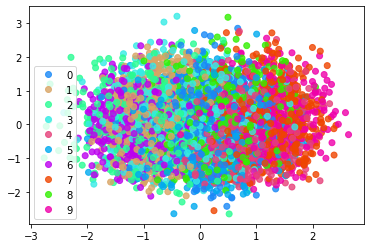

In [7]:
emb_dims = 8
ls = np.array([np.zeros(emb_dims)])
y = np.array([0])
for data, label in train_loader:
    img = data.cuda()
    z, _ = vae.encode(img)
    ls = np.append(ls, z[:, :emb_dims].detach().cpu(), axis=0)
    y = np.append(y, label, axis=0)
    display.display(plt.gcf())
    display.clear_output(wait=True)
    scatter = plt.scatter(ls[:, 0], ls[:, 3], c=y, cmap=colours, alpha=0.8)
    plt.legend(handles=scatter.legend_elements()[0], labels=classes)
    plt.pause(0.1)
    if ls.shape[0] > 5000:
        break

In [8]:
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

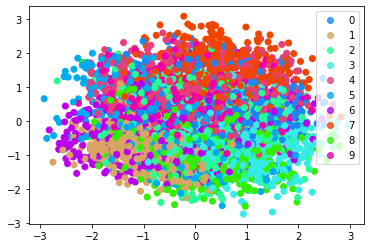

In [9]:
pca = PCA(2)
pipe = Pipeline([('scaler', StandardScaler()), ('pca', pca)])
Xt = pipe.fit_transform(ls)
plot = plt.scatter(Xt[:,0], Xt[:,1], c=y, cmap=colours)
plt.legend(handles=scatter.legend_elements()[0], labels=classes)

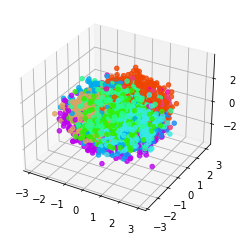

In [10]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

pca = PCA(3)
pipe = Pipeline([('scaler', StandardScaler()), ('pca', pca)])
Xt = pipe.fit_transform(ls)

ax.scatter(Xt[:, 0], Xt[:, 1], Xt[:,2], c=y, cmap=colours, alpha=0.8)

# Save Image for verifying image quality

In [11]:
with torch.no_grad():
    z = torch.randn(64, 8).cuda()
    sample = vae.decode(z).cuda()
    
    save_image(sample.view(64, 1, 28, 28), './samples/mnist_sample_' + '.png')

# Load the obfuscator model

In [12]:
from adversarial_training import ARL

In [13]:
arl_config = {"alpha": 0.99, "obf_in": 8, "obf_out": 8,
              "noise_reg": True, "sigma": 0.01,
              "lip_reg": False, "lip_coeff": 0.01,
              "siamese_reg": True, "lambda": 100.0, "margin": 25}
arl = ARL(arl_config)
arl.load_state()

mnist
loaded vae
sucessfully loaded models


# Visualize the embedding space

In [14]:
emb_dims = 8
obf_dims = 8

z = np.array([np.zeros(emb_dims)])
z_tilde = np.array([np.zeros(obf_dims)])
y = np.array([0])

for data, label in train_loader:
    img = data.cuda()
    
    # compute
    emb, _ = vae.encode(img)
    obf = arl.obfuscator(emb)

    # store
    z = np.append(z, emb.detach().cpu(), axis=0)
    z_tilde = np.append(z_tilde, obf.detach().cpu(), axis=0)
    y = np.append(y, label, axis=0)
    if z.shape[0] > 15000:
        break

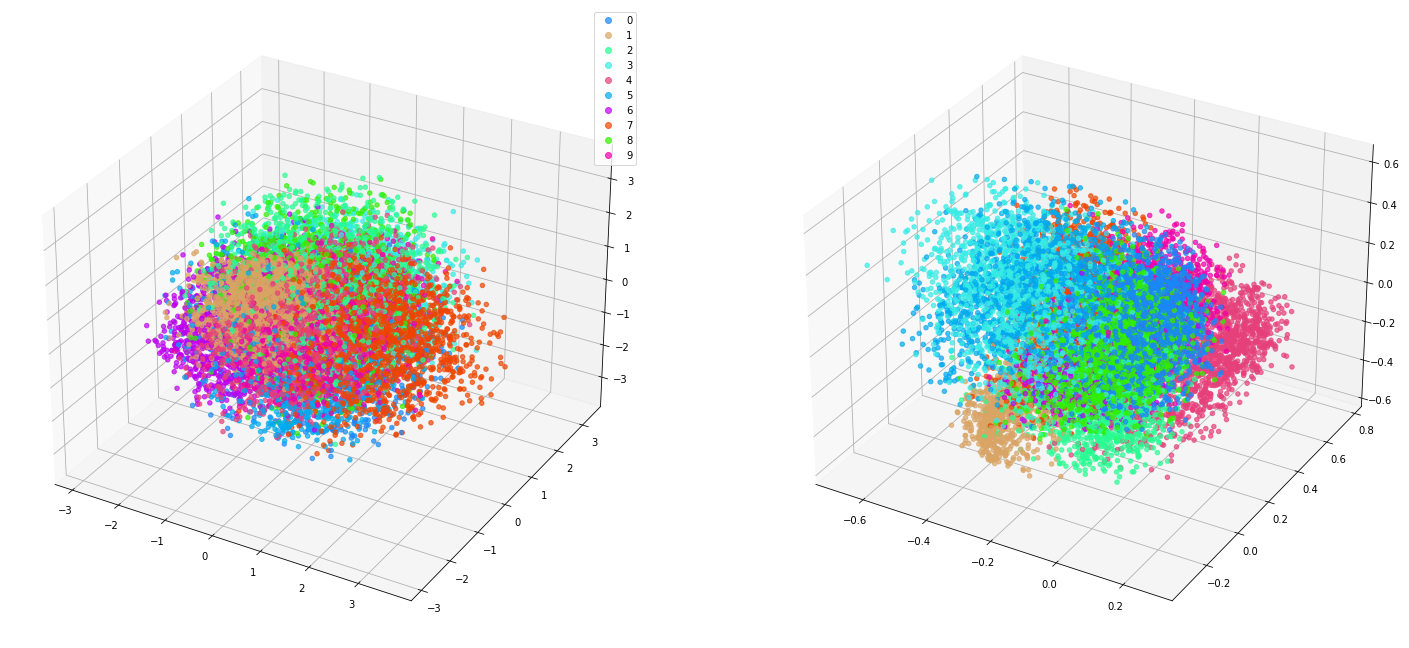

In [19]:
f = plt.figure(figsize=(25, 15))
ax1 = f.add_subplot(1, 2, 1, projection='3d')
ax2 = f.add_subplot(1, 2, 2, projection='3d')

pca = PCA(3)
pipe = Pipeline([('scaler', StandardScaler()), ('pca', pca)])
z_pca = pipe.fit_transform(z)
z_tilde_pca = pipe.fit_transform(z_tilde)

scatter_emb = ax1.scatter(z_pca[:, 0], z_pca[:, 1], z_pca[:, 2], c=y, cmap=colours, alpha=0.7)
#scatter_obf = ax2.scatter(z_tilde_pca[:, 0], z_tilde_pca[:, 1], z_tilde_pca[:, 2], c=y, cmap=colours, alpha=0.7)
scatter_obf = ax2.scatter(z_tilde[:, 0], z_tilde[:, 1], z_tilde[:, 2], c=y, cmap=colours, alpha=0.7)
ax1.legend(handles=scatter_emb.legend_elements()[0], labels=classes)
# ax2.set_xlim(-3, 3)
# ax2.set_ylim(-3, 3)
# ax2.set_zlim(-3, 3)



# Reconstructing Samples

In [23]:
z, _ = vae.encode(data.cuda())
rec = vae.decode(z).cpu().detach()

In [71]:
index = np.random.randint(data.shape[0])

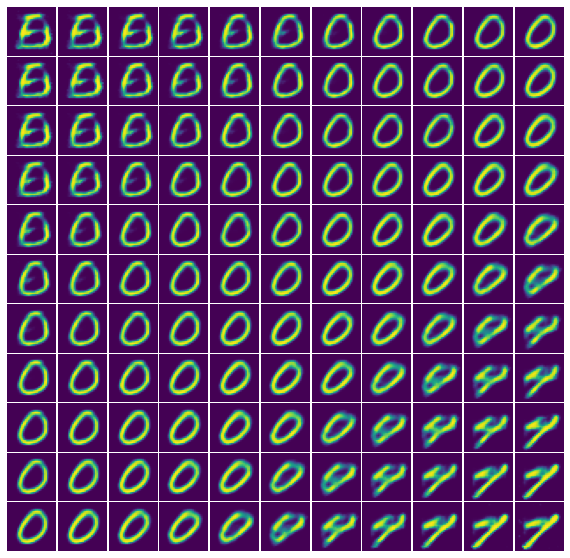

In [72]:
f, ax = plt.subplots(11, 11, figsize=(10, 10))
radius = 1
for i in range(11):
    for j in range(11):
        z_neighbor = z + (i - 5) * radius/5 + (j - 5) * radius/5
        rec_neighbor = vae.decode(z_neighbor).cpu().detach()
        #if i==5 and j==5:
        #    rec_neighbor[rec_neighbor < 0.5] = 0.6
        ax[i][j].imshow(rec_neighbor[index][0])
        ax[i][j].axis("off")
        ax[i][j].set_aspect('equal')
#ax[0].imshow(data[index][0])
#ax[1].imshow(rec[index][0])
#ax[2].imshow(rec_neighbor[index][0])
plt.subplots_adjust(wspace=0.001, hspace=0.015)

In [92]:
z[index] + 0.3

tensor([1.8920, 1.3282, 0.8926, 1.1837, 0.3829, 1.7750, 1.1796, 0.7284],
       device='cuda:0', grad_fn=<AddBackward0>)

In [64]:
index

194

(-0.5, 27.5, 27.5, -0.5)

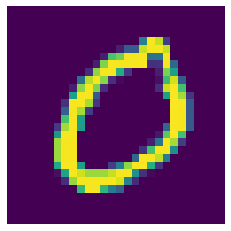

In [73]:
plt.imshow(data[index][0])
plt.axis("off")